# 1. Install Dependencies and Setup

In [2]:
!pip install tensorflow  opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
altgraph                     0.17.2
appnope                      0.1.4
asttokens                    2.4.1
astunparse                   1.6.3
certifi                      2024.8.30
charset-normalizer           3.4.0
comm                         0.2.2
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
et-xmlfile                   1.1.0
exceptiongroup               1.2.1
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.54.1
future                       0.18.2
gast                         0.6.0
google-pasta                 0.2.0
grpcio                       1.67.0
h5py                         3.12.1
idna                         3.10
importlib_metadata           7.2.1
importlib_resources          6.4.5
ipykernel                    6.29.4


In [4]:
import tensorflow as tf
import os

/Users/mohanganesh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [7]:
import cv2
import imghdr

In [8]:
data_dir = 'data' 

In [12]:
os.listdir(data_dir)

['happy', '.DS_Store', 'sad']

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [11]:
for image_class in os.listdir(data_dir):
    image_class_path = os.path.join(data_dir, image_class)
    
    # Skip if it's not a directory
    if not os.path.isdir(image_class_path):
        continue
    
    for image in os.listdir(image_class_path):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}: {e}')

# 3. Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [14]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [15]:
data_iterator = data.as_numpy_iterator()

In [16]:
batch = data_iterator.next()

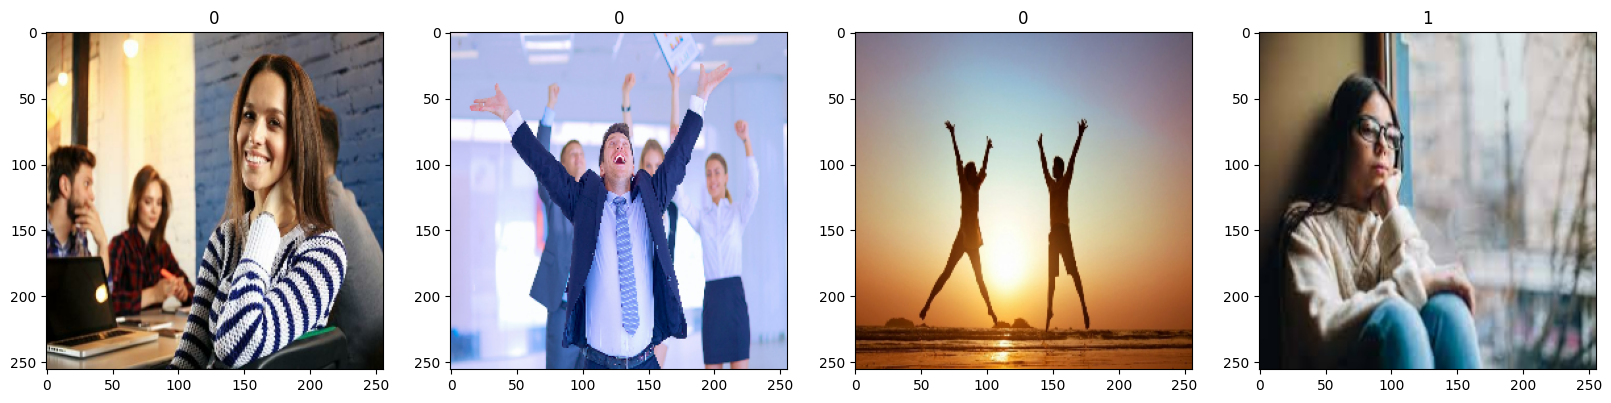

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
data.as_numpy_iterator().next()

(array([[[[0.49116114, 0.30292585, 0.15390626],
          [0.5161382 , 0.3293505 , 0.17984834],
          [0.53574604, 0.35927543, 0.20633425],
          ...,
          [0.29391083, 0.21940105, 0.23508732],
          [0.24307598, 0.16856618, 0.18425246],
          [0.27682292, 0.20231311, 0.21799938]],
 
         [[0.52402365, 0.33578834, 0.18676874],
          [0.53643703, 0.3496493 , 0.20014717],
          [0.5396765 , 0.3632059 , 0.21026474],
          ...,
          [0.31105575, 0.23791249, 0.25314325],
          [0.27530074, 0.20663461, 0.22037299],
          [0.31227103, 0.23803453, 0.2536297 ]],
 
         [[0.55457395, 0.36633867, 0.21731906],
          [0.5559251 , 0.36913744, 0.21936762],
          [0.54332685, 0.3668563 , 0.21173987],
          ...,
          [0.33759516, 0.26831484, 0.2823323 ],
          [0.32296026, 0.26012284, 0.27223626],
          [0.3591628 , 0.2883092 , 0.30279163]],
 
         ...,
 
         [[0.47971773, 0.39954004, 0.33287334],
          [0.51652

# 5. Split Data

In [20]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [21]:
train_size

7

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [23]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Users/mohanganesh/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [29]:
logdir='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 534ms/step - accuracy: 0.5013 - loss: 1.5115 - val_accuracy: 0.8125 - val_loss: 0.6582
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 605ms/step - accuracy: 0.6214 - loss: 0.6684 - val_accuracy: 0.6094 - val_loss: 0.6438
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step - accuracy: 0.6339 - loss: 0.6602 - val_accuracy: 0.6875 - val_loss: 0.5978
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.6051 - loss: 0.6223 - val_accuracy: 0.7969 - val_loss: 0.5523
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step - accuracy: 0.7287 - loss: 0.5599 - val_accuracy: 0.8438 - val_loss: 0.4807
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 465ms/step - accuracy: 0.7591 - loss: 0.4838 - val_accuracy: 0.8125 - val_loss: 0.4149
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.8287 - loss: 0.4082 - val_accuracy: 0.8594 - val_loss: 0.3275
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.9269 - loss: 0.3177 - val_accuracy: 0.8750 - val_loss:

# 8. Plot Performance

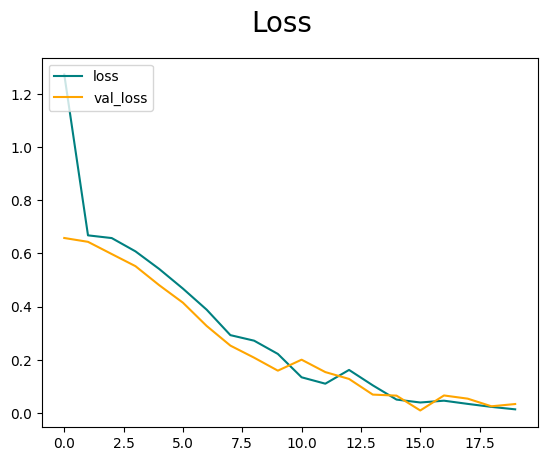

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

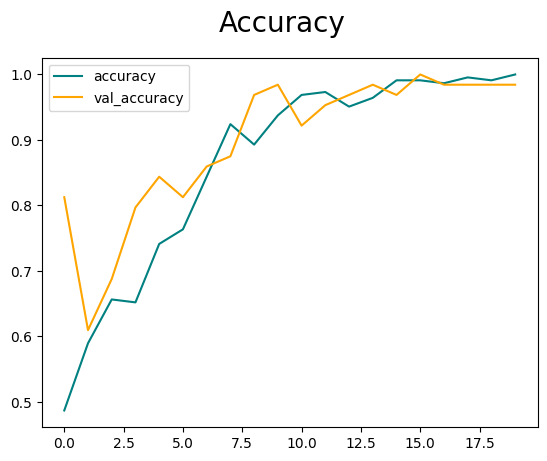

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


2024-10-26 01:16:05.452627: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [38]:
import cv2

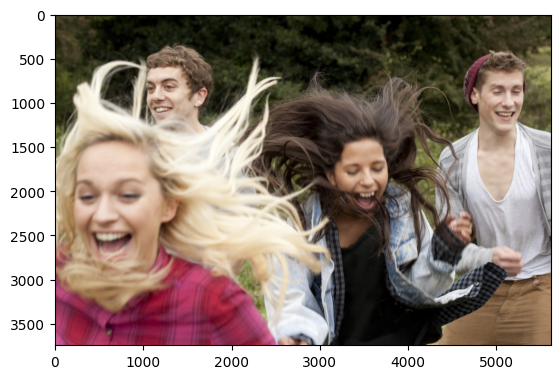

In [41]:
img = cv2.imread('154006829.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

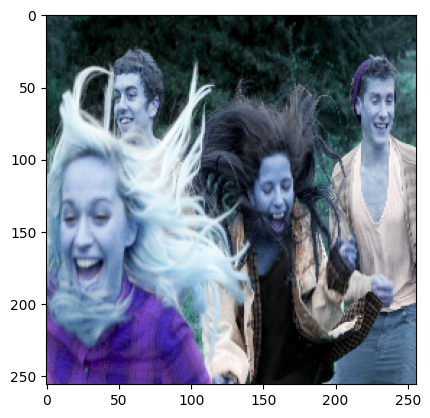

In [42]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [43]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [44]:
yhat

array([[0.01174654]], dtype=float32)

In [45]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [46]:
from tensorflow.keras.models import load_model

In [60]:
model.save('imageclassifier.keras')

In [61]:
new_model = load_model('imageclassifier.keras')

/Users/mohanganesh/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [62]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


array([[0.01174654]], dtype=float32)